In [1]:
import pathlib
import re

## Load the Data

In [2]:
path = pathlib.Path.cwd() / 'excerpt-p17.txt'

In [3]:
with open(path, mode='r', encoding='utf-16-le') as fid:
    lines = [line for line in fid]

## Extract Fields

https://regex101.com/

In [4]:
class Record:
    """
    A simple data class containing fields for each extracted line
    """
    def __init__(self, dept, name, title, state, dist, salary):
        self.dept, self.name, self.title, self.state, self.dist, self.salary = \
            dept, name, title, state, dist, salary
    
    def __str__(self):
        return f"DEPT: {self.dept}\nNAME: {self.name}\nTITLE: {self.title}\nSTATE: {self.state}\nDIST: {self.dist}\nSALARY: {self.salary}"
    
    def to_dict(self):
        return {
            'dept':self.dept,
            'name':self.name,
            'title':self.title,
            'state':self.state,
            'dist':self.dist,
            'salary':self.salary
        }

In [5]:
dept_regex      = r"^\s+([A-Z ]+)\s+$"
name_regex      = r"^\s?([A-Z0]\.?[a-z]*(?:\s[A-Z0]\.?[a-z]*){1,3}(?:,\s*jr)?)"
title_regex     = r"^\s+((?:[A-Z][a-z]{2,},?)(?:\s[A-z]+\'?,?)*)"
state_regex     = r"^\s+([A-Z][a-z\.]{0,3}(?:\s?[A-Z][a-z\.]{0,3})?)"
dist_regex      = r"([0-9]{1,2}(?:d|th|st))"
salary_regex    = r"([1-9]0?(?:,\s?)?[0-9]{2,3})"

In [6]:
# will contain collected records extracted from text
records = []

# initialize dept variable
dept = None

# iterate through lines of text
for line in lines:
    
    # Look for a department match
    dept_match = re.match(dept_regex, line, re.MULTILINE)
    if dept_match: 
        dept = dept_match.group(1)
        continue
    
    # Look for a row to extract a record. Every such row begins with a name,
    # so if we get a name match, we'll look for the other pieces of information
    name, title, state, dist, salary = None, None, None, None, None
    
    # 1: Name match
    name_match = re.match(name_regex, line, re.MULTILINE)
    if name_match:
        name = name_match.group(1)
        line = line[name_match.end(1):]
        
        # 2: Title match
        title_match = re.match(title_regex, line, re.MULTILINE)
        if title_match:
            title = title_match.group(1)
            line = line[title_match.end(1):]
            
        # 3: State match
        state_match = re.match(state_regex, line, re.MULTILINE)
        if state_match:
            state = state_match.group(1)
            state = re.sub(r"[\. ]", '', state)
            state = state.upper()
            line = line[state_match.end(1):]
        
        # 4: District match
        dist_match = re.search(dist_regex, line)
        if dist_match:
            dist = dist_match.group(1)
            line = line[dist_match.end(1):]
            
        # 5: Salary match
        salary_match = re.search(salary_regex, line)
        if salary_match:
            salary = salary_match.group(1)
            salary = int(re.sub(r"[, ]", '', salary))

        # Append the new record to the list of records
        records.append(Record(dept=dept, 
                              name=name, 
                              title=title,
                              state=state, 
                              dist=dist, 
                              salary=salary))

## Normalize state abbreviations with string distance

https://phiresky.github.io/levenshtein-demo/

In [7]:
# list of state abbreviations
state_abbrevs = ["AK","AL","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","\
OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

# turn into a dictionary
states = {s:s for s in state_abbrevs}

# add some entries derived from dataset
states['DC'] = 'DC'
states['MASS'] = 'MA'
states['IOWA'] = 'IA'
states['OHIO'] = 'OH'
states['IND'] = 'IN'
states['NDAK'] = 'ND'
states['SDAK'] = 'SD'
states['CALIF'] = 'CA'
states['D'] = 'DC'

# extract the keys
state_keys = list(states.keys())

In [8]:
import textdistance as td

# use the textdistance package to get closest match
for rec in records:
    if rec.state:
        l = [td.levenshtein(s, rec.state) for s in state_keys]
        rec.state = states[state_keys[l.index(min(l))]]

## Create a Dataframe

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
dict_rows = [rec.to_dict() for rec in records]
df = pd.DataFrame(dict_rows)

In [11]:
df.head()

,dept,dist,name,salary,state,title
0,GOVERNMENT PRINTING OFFICE,9th,George H. Carter,10000,IA,Public Printer
1,GOVERNMENT PRINTING OFFICE,5th,John Greene,7500,MA,Deputy Public Printer
2,GOVERNMENT PRINTING OFFICE,2d,Mary A. Tate,4000,TN,Assistant to the Public Printer
3,GOVERNMENT PRINTING OFFICE,28th,Henry H. Wright,4200,NY,Chief clerk
4,GOVERNMENT PRINTING OFFICE,16th,Edward J. Wilver,4000,PA,Disbursing clerk


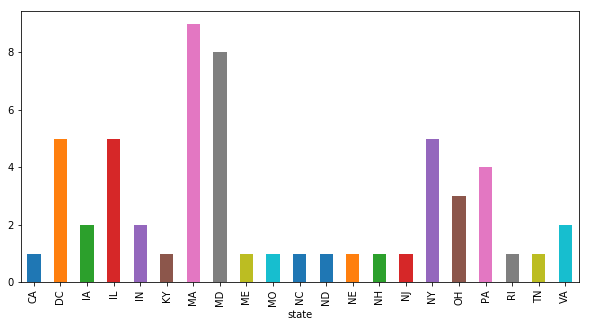

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
df.groupby(['state'])['name'].count().plot.bar(x='state')

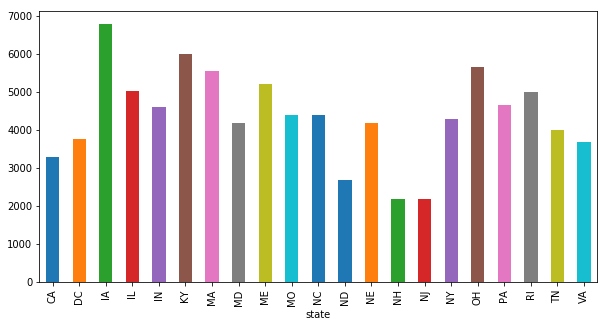

In [13]:
df.groupby(['state'])['salary'].mean().plot.bar(x='salary')

In [14]:
df.to_csv('records.csv', sep=',', index=False, encoding='utf-8')

## Pattern Matching with spaCy

https://spacy.io/

https://explosion.ai/demos/

In [15]:
import spacy
from spacy.matcher import Matcher
from spacy import displacy
import pathlib

In [16]:
nlp = spacy.load('en')

In [17]:
excerpt_text = (pathlib.Path.cwd() / 'excerpt-p17.txt').read_text(encoding='utf-16-le')

In [18]:
excerpt_doc = nlp(excerpt_text)

In [19]:
matcher = Matcher(nlp.vocab)
pattern = [{'IS_UPPER': True, 'IS_ALPHA': True, 'OP': '+'}, 
           {'IS_UPPER': True, 'IS_ALPHA': True, 'OP': '+'},
           {'IS_UPPER': True, 'IS_ALPHA': True, 'OP': '+'},
          ]
matcher.add('upper_seq', None, pattern)

matches = matcher(excerpt_doc)
for _, start, end in matches:
    span = excerpt_doc[start:end]
    if len(span.text) > 10 and excerpt_doc[start-1].is_space and excerpt_doc[end].is_space:
        print(f"{span.text} ({start}, {end})")

GOVERNMENT PRINTING OFFICE (13, 16)
LIBRARY OF CONGRESS (449, 452)
UNITED STATES BOTANIC GARDEN (1113, 1117)


## spaCy with more fluent text

In [20]:
radiology_text = (pathlib.Path.cwd() / 'radiology.txt').read_text()

In [21]:
print(radiology_text)

HISTORY:
TRAUMA, ASSESS FOR HEMORRHAGE
REPORT
HISTORY: As above.
COMPARISON: No relevant prior examinations available.
TECHNIQUE: Head CT without contrast.
FINDINGS:
There is a predominantly hyperdense extra axial collection layering over the left cerebral
convexity and left tentorium, consistent with a subdural hematoma. The component overlying the
left cerebral convexity measures 11-mm and the tentorial component measures 15-mm.
There is associated mass effect with effacement of the adjacent left cerebral sulci and left lateral
ventricle and 6-mm of rightward midline shift. There is mild subfalcine herniation. There is no
uncal herniation. There is also a small amount of subdural hemorrhage along the falx and right
tentorium.
There is hypodensity in the periventricular and subcortical white matter, a nonspecific finding
that is often seen in patients with microangiopathic changes. The brain parenchyma is otherwise
unremarkable. There is no evidence of intracranial mass lesion, acute 

In [22]:
radiology_doc = nlp(radiology_text)

In [23]:
sents = list(radiology_doc.sents)
for sent in sents:
    print(f"[SENT]: {sent.text}")

[SENT]: HISTORY:
TRAUMA, ASSESS FOR HEMORRHAGE
REPORT
HISTORY:
[SENT]: As above.

[SENT]: COMPARISON:
[SENT]: No relevant prior examinations available.

[SENT]: TECHNIQUE: Head CT without contrast.

[SENT]: FINDINGS:

[SENT]: There is a predominantly hyperdense extra axial collection layering over the left cerebral
convexity and left tentorium, consistent with a subdural hematoma.
[SENT]: The component overlying the
left cerebral convexity measures 11-mm and the tentorial component measures 15-mm.

[SENT]: There is associated mass effect with effacement of the adjacent left cerebral sulci and left lateral
ventricle and 6-mm of rightward midline shift.
[SENT]: There is mild subfalcine herniation.
[SENT]: There is no
uncal herniation.
[SENT]: There is also a small amount of subdural hemorrhage along the falx and right
tentorium.

[SENT]: There is hypodensity in the periventricular and subcortical white matter, a nonspecific finding
that is often seen in patients with microangiopathic cha

In [24]:
for nc in radiology_doc.noun_chunks:
    print(nc)

HISTORY
TRAUMA
HEMORRHAGE
REPORT
COMPARISON
No relevant prior examinations
TECHNIQUE
Head CT
contrast
FINDINGS
a predominantly hyperdense extra axial collection
the left cerebral
convexity and left tentorium
a subdural hematoma
The component
cerebral convexity measures
associated mass effect
effacement
lateral
ventricle
rightward midline shift
mild subfalcine herniation
no
uncal herniation
a small amount
subdural hemorrhage
the falx
tentorium
hypodensity
the periventricular and subcortical white matter
a nonspecific finding
patients
microangiopathic changes
The brain parenchyma
no evidence
intracranial mass lesion
acute infarction
scattered mucosal thickening
the paranasal sinuses
The bilateral mastoid air cells
A prosthesis
the right globe
a large posterior subgaleal hematoma
No fracture
IMPRESSION
Predominantly hyperdense
subdural hematoma
the left cerebral convexity
up to 15 mm
greatest diameter
a small amount
subdural hemorrhage
the right tentorium
the falx
associated mass effect
r

In [25]:
print(sents[9])
displacy.render(sents[9], style='dep', jupyter=True)

There is mild subfalcine herniation.
